# Modelo de red neuronal convolucional base (50 capas)

En este notebook construiremos un modelo de red neuronal convolucional con 50 capas entrenables, inspirado en la arquitectura ResNet-50, pero sin conexiones residuales. Los detalles del entrenamiento y de los datos pueden ser consultados en el notebook "./ResNet-50.ipynb".

### Preparación de los datos

In [1]:
# Importamos las paqueterías necesarias para el notebook
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=False,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

La estructura del modelo es la misma que ResNet-50, pero sin conexiones residuales. Como el modelo empieza con una capa convolucional, cada bloque Bottleneck tiene 3 capas convolucionales y el modelo termina con una capa lineal, este modelo tiene un total de 1+(3+4+6+3)\*3+1=50 capas entrenables

In [3]:
class utilConv(nn.Sequential):
    def __init__(self, in_features, out_features, kernel_size, stride = 1, norm = nn.BatchNorm2d, act = nn.ReLU, bias=True):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size ,padding=kernel_size // 2, stride=stride, bias=bias),
            norm(out_features),
            act()
        )

class BottleNeckBlock(nn.Module):
    def __init__(self,in_features, out_features, reduction = 4, stride = 1):
        super().__init__()
        reduced_features = out_features // reduction
        self.block = nn.Sequential(
            # Reducción de canales
            utilConv(in_features, reduced_features, kernel_size=1, stride=stride, bias=False), # el stride puede ser 2 para aplicar downsampling
            # El número de canales se mantiene fijo
            utilConv(reduced_features, reduced_features, kernel_size=3, bias=False),
            # Aumento de canales
            utilConv(reduced_features, out_features, kernel_size=1, bias=False), 
        )
        
        if in_features != out_features:
            self.shortcut =nn.Sequential(utilConv(in_features, out_features, kernel_size=1, stride=stride, bias=False))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        x = self.block(x)
        return x

In [4]:
#segundo intento 
class ConvNet_50_capas(nn.Module):
    """
    Modelo de red neuronal convolucional de 50 capas para clasificar imágenes en 10 clases posibles
    """
    def __init__(self):
        super().__init__()
        self.conv1 = utilConv(3,64,kernel_size=3)
        
        self.bloc1 = nn.Sequential(BottleNeckBlock(64,64,stride=1),
                                   *[BottleNeckBlock(64,64) for _ in range(3-1)])
        
        self.bloc2 = nn.Sequential(BottleNeckBlock(64, 128, stride=2),
                                   *[BottleNeckBlock(128,128) for _ in range(4-1)])
        
        self.bloc3 = nn.Sequential(BottleNeckBlock(128,256,stride=2),
                                   *[BottleNeckBlock(256,256) for _ in range(6-1)])
   
        self.bloc4 = nn.Sequential(BottleNeckBlock(256,512,stride=2),
                                   *[BottleNeckBlock(512,512) for _ in range(3-1)])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512,10)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bloc1(out)
        out = self.bloc2(out)
        out = self.bloc3(out)
        out = self.bloc4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim = 1)
        return out

### Entrenamiento

In [5]:
def entrenamiento():
    # variables para guardar los resultados
    accuracy_training_epochs = []
    accuracy_validation_epochs = []
    loss_epoch = []
    test_accuracy = []
    
    # hiperparámetros
    num_epochs = 90

    model = ConvNet_50_capas().to(device)

    optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=60, gamma=0.1)

    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    # entrenamiento
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, (images, labels) in enumerate(train_loader):

            # Mover a los tensores a GPU de ser posible
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y descenso de gradiente estocástico
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ahorro de memoria
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        loss_epoch.append(loss.item())
        lr_scheduler.step() # Implementación de learning rate decay

        # Exactitud en el conjunto de validación
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            val_accuracy = correct/total
            accuracy_validation_epochs.append(val_accuracy)

        # Exactitud en el total del conjunto de entrenamiento
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            train_accuracy = correct/total
            accuracy_training_epochs.append(train_accuracy)

        # Exactitud en el conjunto de prueba
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            t_acc = correct/total
            test_accuracy.append(t_acc)



        print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
        print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
        
    return [model,
            accuracy_training_epochs,
            accuracy_validation_epochs,
            test_accuracy,
            loss_epoch]  # model, training accuracy, validation accuracy, test accuracy, loss

In [6]:
# repetimos 3 veces el experimento
model1, training1, validation1, test1, loss1 = entrenamiento()
model2, training2, validation2, test2, loss2 = entrenamiento()
model3, training3, validation3, test3, loss3 = entrenamiento()

Epoch [1/90], Training accuracy: 0.16, Validation accuracy: 0.17, loss = 2.277
Time spent on epoch 1: 3.15min
Epoch [2/90], Training accuracy: 0.209, Validation accuracy: 0.209, loss = 2.241
Time spent on epoch 2: 3.12min
Epoch [3/90], Training accuracy: 0.26, Validation accuracy: 0.27, loss = 2.035
Time spent on epoch 3: 3.12min
Epoch [4/90], Training accuracy: 0.233, Validation accuracy: 0.235, loss = 1.933
Time spent on epoch 4: 3.1min
Epoch [5/90], Training accuracy: 0.273, Validation accuracy: 0.277, loss = 2.201
Time spent on epoch 5: 3.09min
Epoch [6/90], Training accuracy: 0.268, Validation accuracy: 0.267, loss = 2.304
Time spent on epoch 6: 3.09min
Epoch [7/90], Training accuracy: 0.265, Validation accuracy: 0.27, loss = 2.333
Time spent on epoch 7: 3.1min
Epoch [8/90], Training accuracy: 0.251, Validation accuracy: 0.251, loss = 2.268
Time spent on epoch 8: 3.09min
Epoch [9/90], Training accuracy: 0.276, Validation accuracy: 0.283, loss = 2.141
Time spent on epoch 9: 3.09min

Epoch [74/90], Training accuracy: 0.504, Validation accuracy: 0.508, loss = 2.007
Time spent on epoch 74: 3.08min
Epoch [75/90], Training accuracy: 0.507, Validation accuracy: 0.516, loss = 2.167
Time spent on epoch 75: 3.08min
Epoch [76/90], Training accuracy: 0.511, Validation accuracy: 0.516, loss = 2.081
Time spent on epoch 76: 3.09min
Epoch [77/90], Training accuracy: 0.513, Validation accuracy: 0.529, loss = 2.003
Time spent on epoch 77: 3.08min
Epoch [78/90], Training accuracy: 0.514, Validation accuracy: 0.514, loss = 2.113
Time spent on epoch 78: 3.08min
Epoch [79/90], Training accuracy: 0.515, Validation accuracy: 0.516, loss = 2.069
Time spent on epoch 79: 3.09min
Epoch [80/90], Training accuracy: 0.518, Validation accuracy: 0.515, loss = 2.148
Time spent on epoch 80: 3.08min
Epoch [81/90], Training accuracy: 0.523, Validation accuracy: 0.513, loss = 1.946
Time spent on epoch 81: 3.08min
Epoch [82/90], Training accuracy: 0.516, Validation accuracy: 0.513, loss = 1.905
Time s

Epoch [57/90], Training accuracy: 0.389, Validation accuracy: 0.389, loss = 2.226
Time spent on epoch 57: 3.08min
Epoch [58/90], Training accuracy: 0.423, Validation accuracy: 0.436, loss = 2.187
Time spent on epoch 58: 3.08min
Epoch [59/90], Training accuracy: 0.391, Validation accuracy: 0.389, loss = 1.958
Time spent on epoch 59: 3.08min
Epoch [60/90], Training accuracy: 0.431, Validation accuracy: 0.438, loss = 1.798
Time spent on epoch 60: 3.09min
Epoch [61/90], Training accuracy: 0.473, Validation accuracy: 0.472, loss = 2.019
Time spent on epoch 61: 3.08min
Epoch [62/90], Training accuracy: 0.485, Validation accuracy: 0.473, loss = 2.204
Time spent on epoch 62: 3.09min
Epoch [63/90], Training accuracy: 0.489, Validation accuracy: 0.482, loss = 1.987
Time spent on epoch 63: 3.07min
Epoch [64/90], Training accuracy: 0.492, Validation accuracy: 0.484, loss = 2.043
Time spent on epoch 64: 3.08min
Epoch [65/90], Training accuracy: 0.495, Validation accuracy: 0.499, loss = 1.623
Time s

Epoch [40/90], Training accuracy: 0.39, Validation accuracy: 0.391, loss = 2.143
Time spent on epoch 40: 3.17min
Epoch [41/90], Training accuracy: 0.377, Validation accuracy: 0.375, loss = 2.299
Time spent on epoch 41: 3.17min
Epoch [42/90], Training accuracy: 0.358, Validation accuracy: 0.363, loss = 1.999
Time spent on epoch 42: 3.17min
Epoch [43/90], Training accuracy: 0.385, Validation accuracy: 0.391, loss = 2.128
Time spent on epoch 43: 3.17min
Epoch [44/90], Training accuracy: 0.372, Validation accuracy: 0.37, loss = 2.082
Time spent on epoch 44: 3.18min
Epoch [45/90], Training accuracy: 0.391, Validation accuracy: 0.39, loss = 2.262
Time spent on epoch 45: 3.17min
Epoch [46/90], Training accuracy: 0.393, Validation accuracy: 0.403, loss = 2.089
Time spent on epoch 46: 3.18min
Epoch [47/90], Training accuracy: 0.392, Validation accuracy: 0.401, loss = 2.048
Time spent on epoch 47: 3.19min
Epoch [48/90], Training accuracy: 0.4, Validation accuracy: 0.403, loss = 1.791
Time spent 

In [7]:
# guardar uno de los modelos
torch.save(model1,"./model_ConvNet-50.pt")

### Resultados

In [8]:
# Guardar en csv
results_dict1 = {"loss": loss1,
    'Train':training1,
     'Validation': validation1,
     "Test":test1}
results_dict2 = {"loss": loss2,
    'Train':training2,
     'Validation': validation2,
     "Test":test2}
results_dict3 = {"loss": loss3,
    'Train':training3,
     'Validation': validation3,
     "Test":test3}

pd.DataFrame(results_dict1).to_csv("./results/results_ConvNet50_1.csv",index=False)
pd.DataFrame(results_dict2).to_csv("./results/results_ConvNet50_2.csv",index=False)
pd.DataFrame(results_dict3).to_csv("./results/results_ConvNet50_3.csv",index=False)

In [9]:
results1 = pd.DataFrame(results_dict1)
results2 = pd.DataFrame(results_dict2)
results3 = pd.DataFrame(results_dict3)

In [10]:
# Accuracy 
accuracy = (results1["Test"].max() + results2["Test"].max() + results3["Test"].max())/3
print(accuracy)

0.5385000000000001


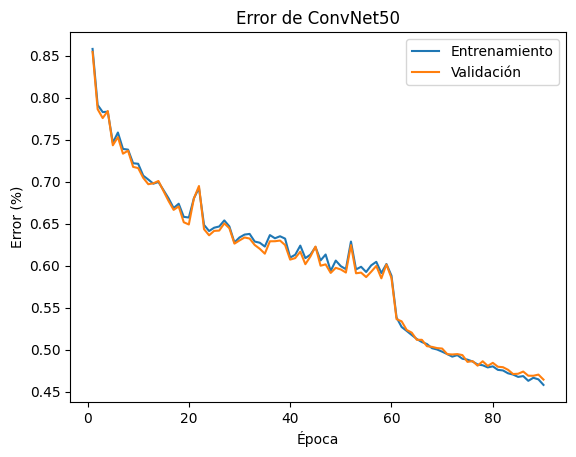

In [13]:
# graficar resultados
x_axis = np.arange(90)+1
validation_err = 1- (np.array(validation1) + np.array(validation2) + np.array(validation3) )/3
train_err = 1- (np.array(training1)+np.array(training2)+np.array(training3))/3

plt.plot(x_axis, train_err)
plt.plot(x_axis, validation_err)
# plt.plot(x_axis, np.ones(90)*0.5, 'k--', linewidth = 0.5)
plt.title("Error de ConvNet50")
plt.ylabel('Error (%)')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()
plt.close()

In [12]:
# Fin